<a href="https://colab.research.google.com/github/manpriyad/Alt/blob/master/CapstoneDemo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Credit Risk**

Creditors provide Loan to Borrowers. Based on trust, Borrower is suppose to repay the lender at some point in future.

Likelihood that Borrower will not repay to creditor is known as Credit Risk. 

Before providing Loan , creditors must assess Credit Risk associated with each borrower. 

**Financial Impact :**

Lending Loans to Borrowers with high probability of default led to 2008 Financial crisis. 

**Problem Statement :**

Aim to identify patterns which indicate if a person is likely to default Loan.
This information can be used by Creditors for denying or reducing the amount of Loan.

**Business Problem :**

Build a model which will give a more comprehensive assessment of Borrowers which will help to identify potential defaulters

In [235]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [237]:
# df=pd.read_csv('/content/loan.csv')
df_description=pd.read_excel('/content/drive/MyDrive/manish/ms/LCDataDictionary.xlsx')
df=pd.read_csv('/content/drive/MyDrive/manish/ms/loan_data_2007_2014.csv')



In [238]:
df_description.head()

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan...
1,annual_inc,The self-reported annual income provided by th...
2,annual_inc_joint,The combined self-reported annual income provi...
3,application_type,Indicates whether the loan is an individual ap...
4,collection_recovery_fee,post charge off collection fee


In [239]:
df.set_index('id')
df.drop('Unnamed: 0',inplace=True,axis=1)

In [240]:
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
df['application_type'].value_counts()

INDIVIDUAL    466285
Name: application_type, dtype: int64

In [242]:
categorical_cols = ['grade', 'sub_grade', 'purpose', 'loan_status', 'home_ownership', 'emp_length', 'application_type']
id_cols = ['member_id',]
time_cols = ['term', 'mths_since_last_record', 'issue_d', 'last_pymnt_d', 'next_pymnt_d']
status_cols = ['loan_status', 'verification_status', 'initial_list_status']
location_cols = ['zip_code', 'addr_state']
numerical_cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', \
                  'total_pymnt', 'annual_inc', 'installment', 'open_acc', 'dti', 'emp_length' , 'out_prncp']
desc_cols = ['url', 'desc', 'title']

In [243]:
df.drop(['url','desc','zip_code','emp_title','title','id','member_id','application_type'],axis=1,inplace=True)

In [244]:
df.shape

(466285, 66)

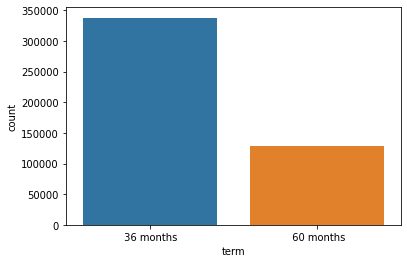

In [245]:
sns.countplot(df['term'])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

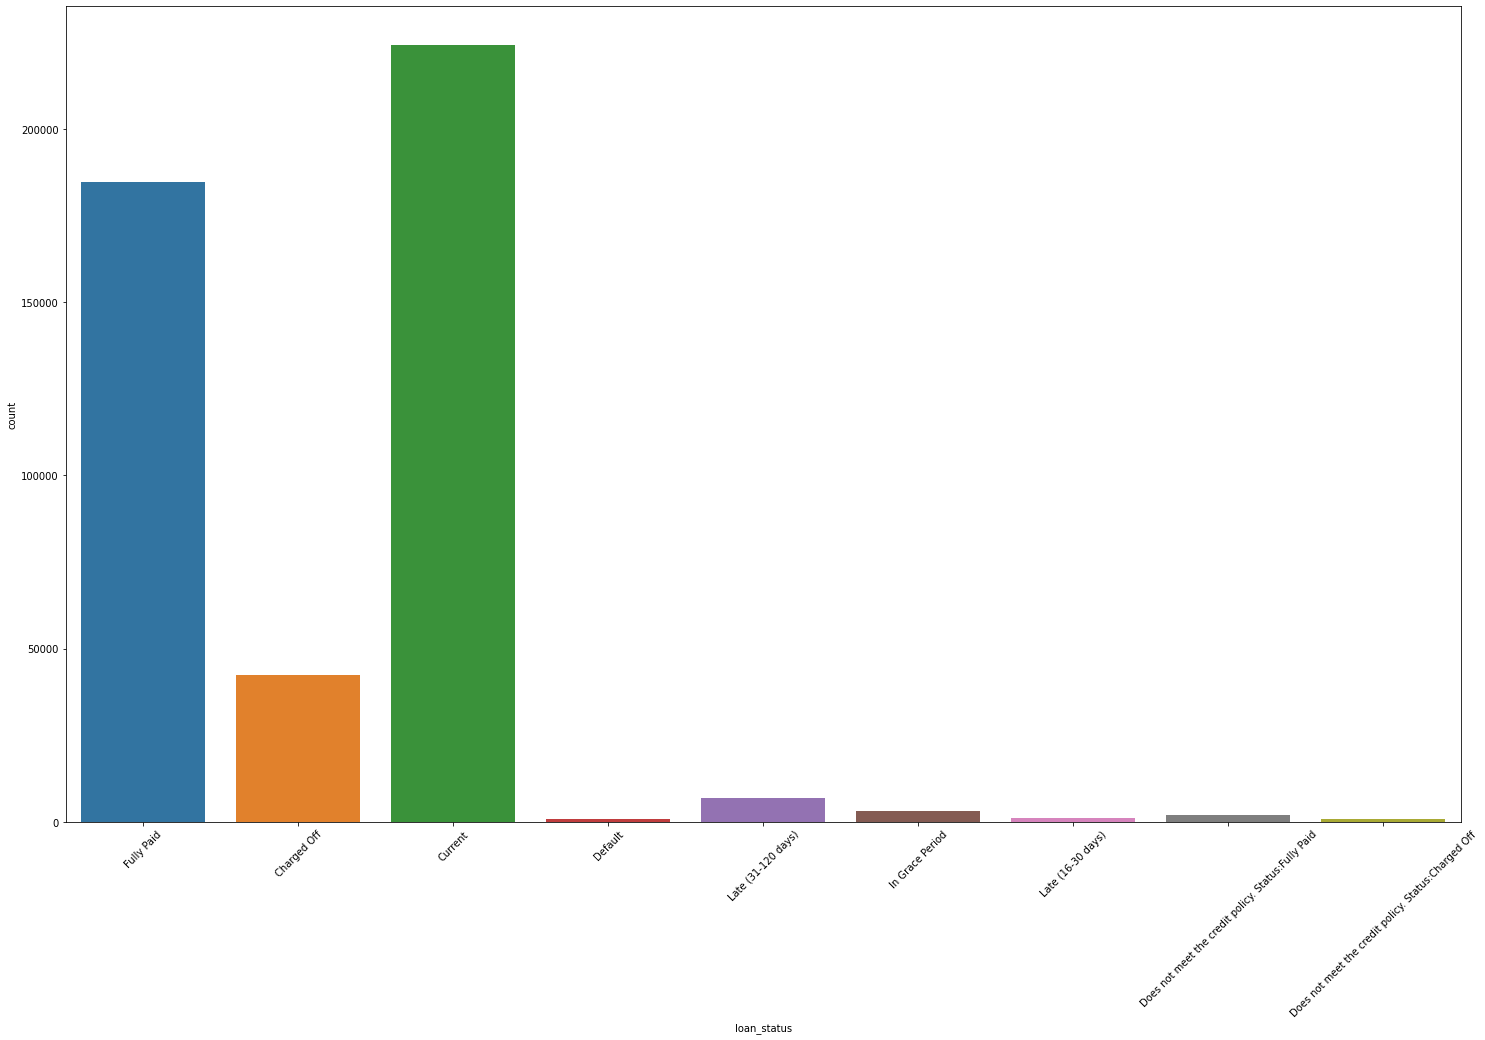

In [246]:
plt.figure(figsize=(25,15))
sns.countplot(df['loan_status'])
plt.xticks(rotation=45)

Removing records with loan status as "Current", as the loan is currently running and we can't infer any information regarding default from such loans.

In [247]:
df=df[df['loan_status']!='Current']

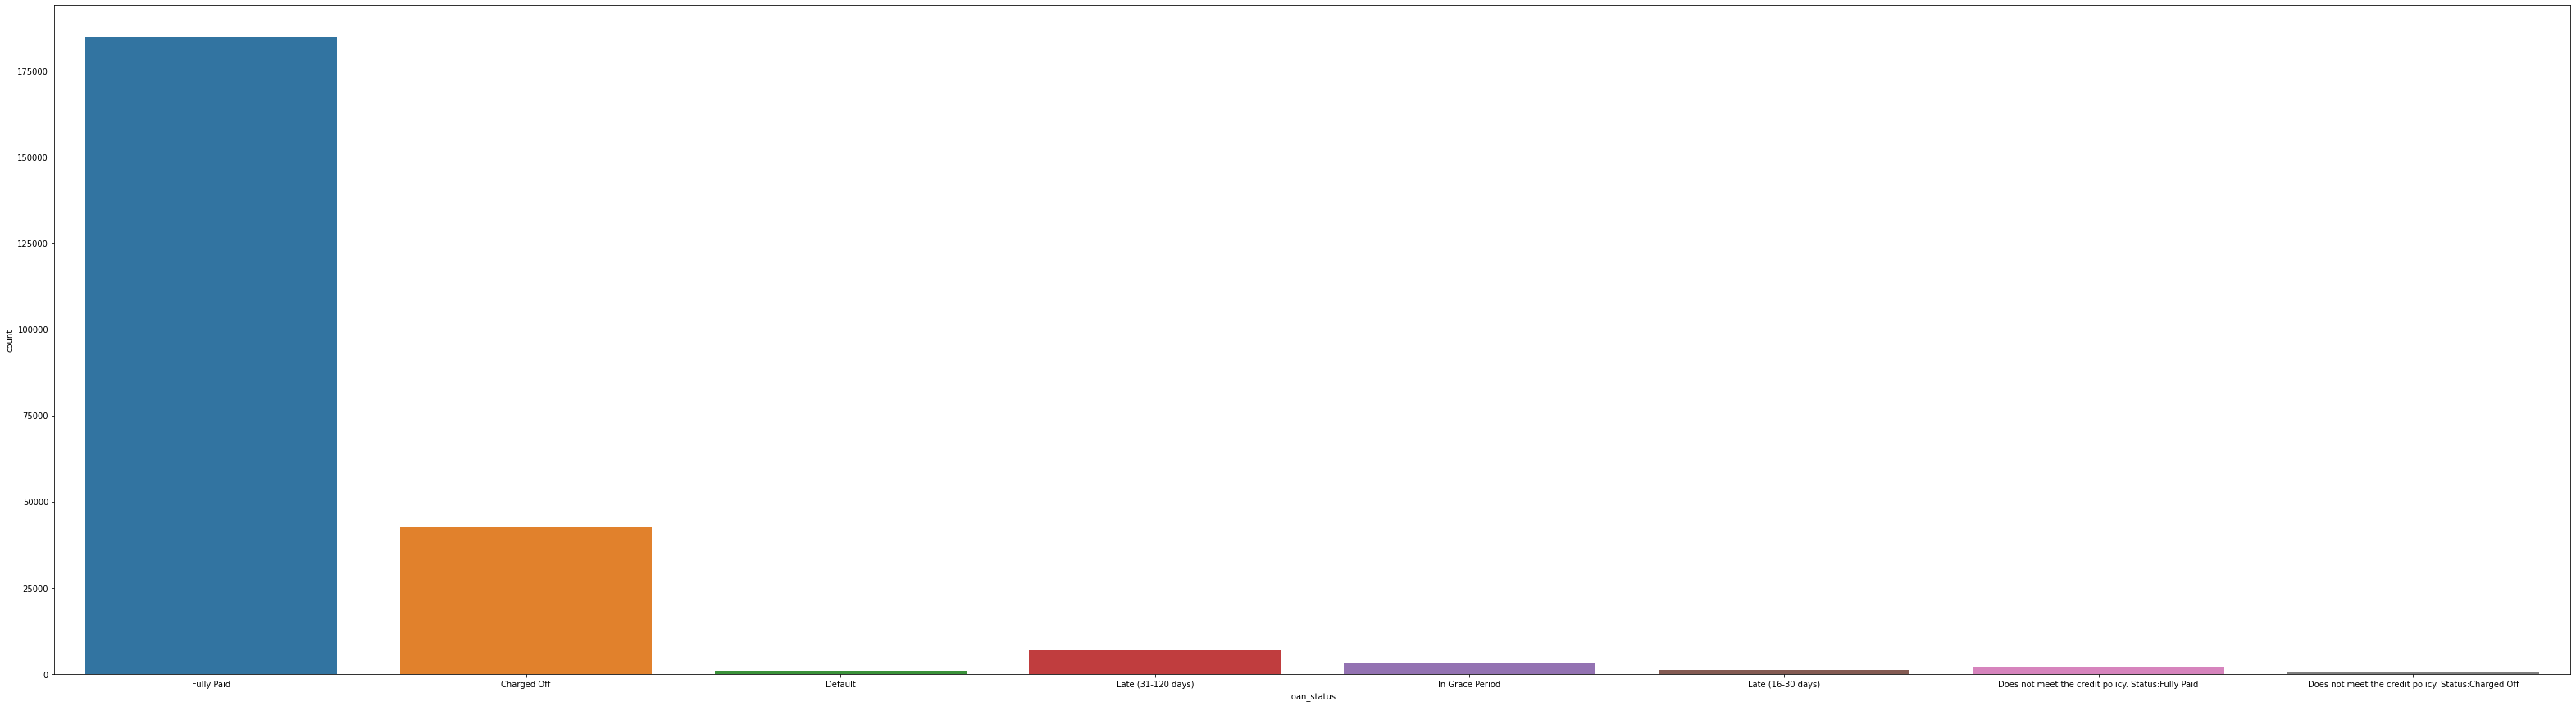

In [248]:
plt.figure(figsize=(55,15))
sns.countplot(df['loan_status'])

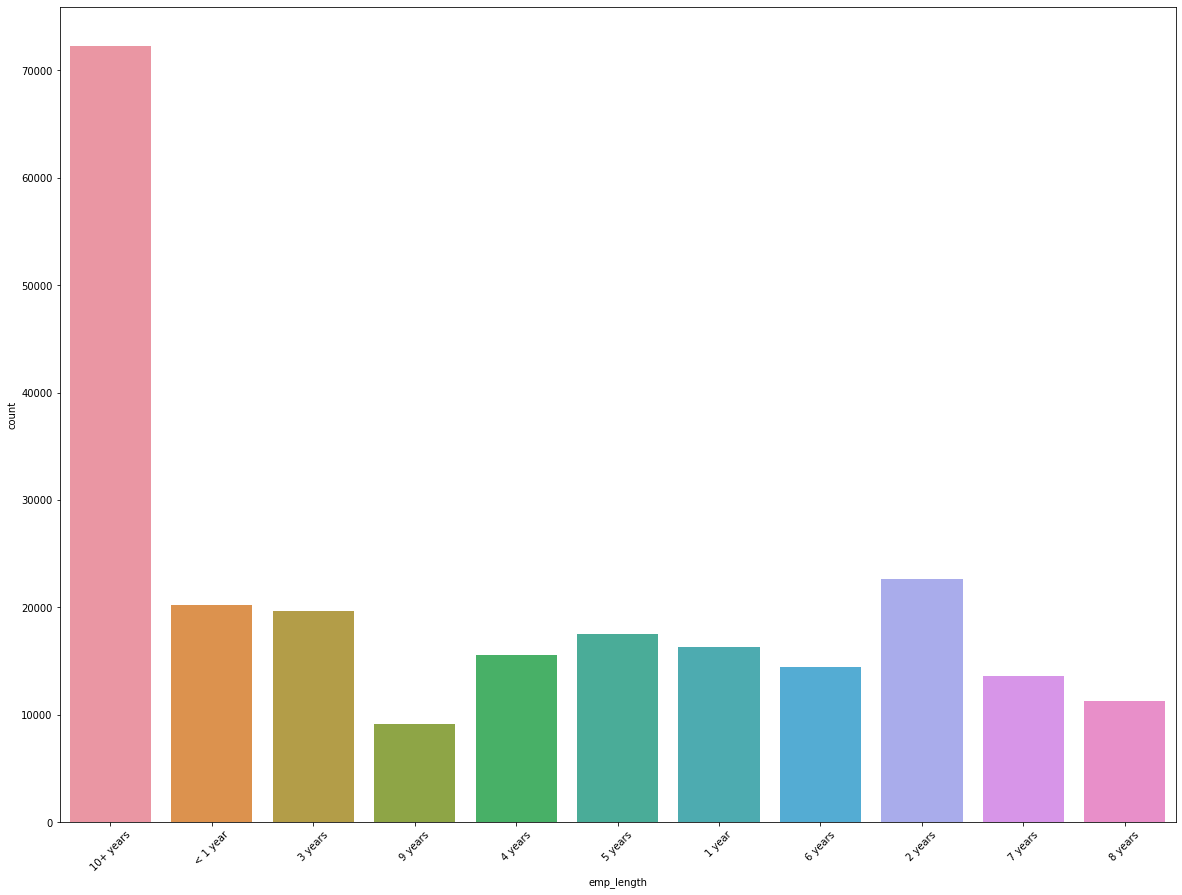

In [249]:
plt.figure(figsize=(20,15))
sns.countplot(df['emp_length'])
plt.xticks(rotation=45)
plt.show()


In [250]:

missing_value_cnt = df.isnull().sum()
percentage = 100 * df.isnull().sum() / len(df)
data_types = df.dtypes
missing_values_table = pd.concat([missing_value_cnt, percentage, data_types], axis=1)
missing_values_table = missing_values_table.rename(columns = {0 : 'Missing Values', 1 : 'Percentage',2 : 'Data Types'})
print (missing_values_table[missing_values_table['Percentage']>70])


                             Missing Values  Percentage Data Types
mths_since_last_record               212660   87.854614    float64
next_pymnt_d                         227214   93.867198     object
mths_since_last_major_derog          198640   82.062638    float64
annual_inc_joint                     242059  100.000000    float64
dti_joint                            242059  100.000000    float64
verification_status_joint            242059  100.000000    float64
open_acc_6m                          242059  100.000000    float64
open_il_6m                           242059  100.000000    float64
open_il_12m                          242059  100.000000    float64
open_il_24m                          242059  100.000000    float64
mths_since_rcnt_il                   242059  100.000000    float64
total_bal_il                         242059  100.000000    float64
il_util                              242059  100.000000    float64
open_rv_12m                          242059  100.000000    flo

In [251]:
cols_to_be_dropped=missing_values_table[missing_values_table['Percentage']>70].index
len (cols_to_be_dropped)

20

In [252]:
df.drop([cols for cols in cols_to_be_dropped], axis=1,inplace=True)
df.shape

(242059, 46)

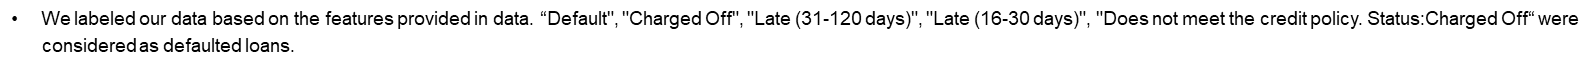

In [253]:
df['good_bad'] = np.where(df['loan_status'].isin(['Charged Off', 'Default',
                                                               'Does not meet the credit policy. Status:Charged Off',
                                                               'Late (31-120 days)','Late (16-30 days)']), 0, 1)

0 represents defaults or Bad Loan and 1 represents non-default or Good Loan

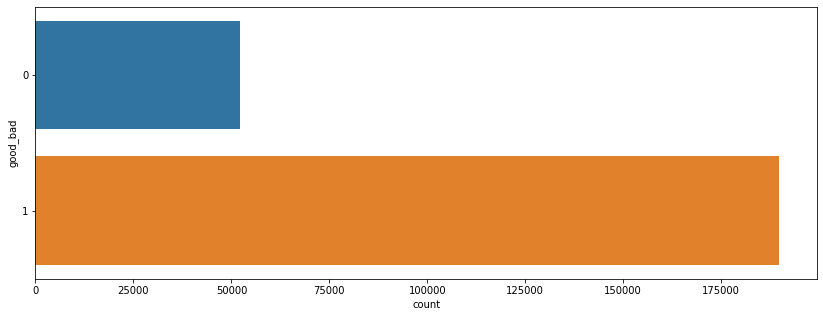

In [254]:
# check for amount of defaulters in the data using countplot
plt.figure(figsize=(14,5))
sns.countplot(y="good_bad", data=df)
plt.show()

In [255]:
# int_rate and revol_util are percentage strings
print (df['int_rate'].head(2))
print (df['revol_util'].head(2))

0    10.65
1    15.27
Name: int_rate, dtype: float64
0    83.7
1     9.4
Name: revol_util, dtype: float64


revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).

In [256]:
# Distribution of interest rate charged to customers
df['int_rate'].describe()

count    242059.000000
mean         13.881078
std           4.386245
min           5.420000
25%          10.990000
50%          13.670000
75%          16.770000
max          26.060000
Name: int_rate, dtype: float64

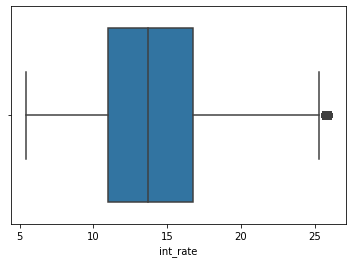

In [257]:
sns.boxplot (df['int_rate'])

In [258]:
# Distribution of Annual Income
df['annual_inc'].describe()


count    2.420550e+05
mean     7.195602e+04
std      5.507293e+04
min      1.896000e+03
25%      4.500000e+04
50%      6.150000e+04
75%      8.600000e+04
max      7.141778e+06
Name: annual_inc, dtype: float64

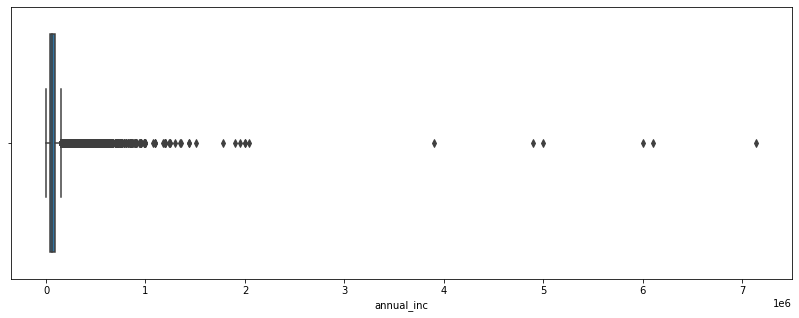

In [259]:

plt.figure(figsize=(14,5))
sns.boxplot(df['annual_inc'])

As evident people with very low income were also offered Loans 

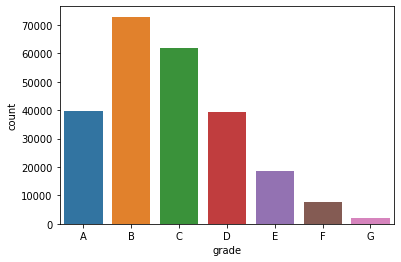

In [260]:
# grade
level_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.countplot(data = df, x = 'grade', order=level_order)

Most of the Borrowers are belonging to category A and B. Also low categories have very less number of borrowers

[Text(0, 0.5, 'Defaulter %'),
 Text(0.5, 0, 'Grades'),
 Text(0.5, 1.0, 'Loan defaults wrt Grade')]

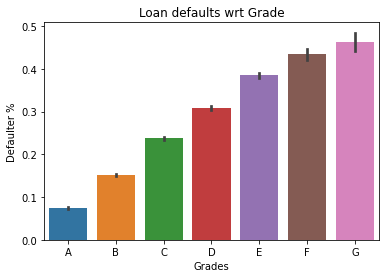

In [264]:
# Since 0 represents Bad loan 
level_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
ax=sns.barplot(y=df['good_bad']== 0, x = df['grade'], order=level_order)
ax.set(ylabel="Defaulter %", xlabel = "Grades",title='Loan defaults wrt Grade')



Most of Defaulters belong to lower grades

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

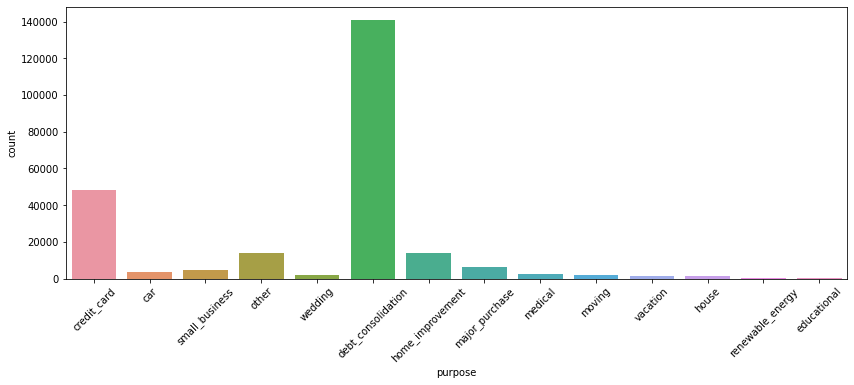

In [265]:
plt.figure(figsize=(14,5))
sns.countplot(df['purpose'])
plt.xticks(rotation=45)

In [266]:
df.head(2)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_bad
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,credit_card,AZ,27.65,0.0,Jan-85,1.0,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-15,171.62,Jan-16,0.0,1,0.0,NaN,NaN,NaN,1
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,car,GA,1.00,0.0,Apr-99,5.0,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-13,119.66,Sep-13,0.0,1,0.0,NaN,NaN,NaN,0


In [267]:
df.shape

(242059, 47)